In [160]:
import pandas as pd
import numpy as np
import warnings
# Reproducibility
import random
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats to get trend
from statsmodels.tsa.seasonal import seasonal_decompose

# scikit-learn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Tensorflow (for LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)


# Import data

In [161]:
path = r"C:/Users/Field Employee/Desktop/AzureNew/DataScienceProcess/ApplicationsAndModels/Models/Query1.xlsx"
df = pd.read_excel(path)

In [162]:
df.columns

Index(['SalesDate', 'CustomerName', 'C_TotalSales'], dtype='object')

In [163]:
df = df[['C_TotalSales','SalesDate']].loc[df['C_TotalSales'] != 0]
# Rename date series 'ds' and time series 'ts'
DF = df.rename(columns = {'SalesDate': 'ds', 'C_TotalSales': 'ts'})

In [164]:
DF.isna().sum()


ts    0
ds    0
dtype: int64

# Initial Analysis

<Axes: xlabel='ds'>

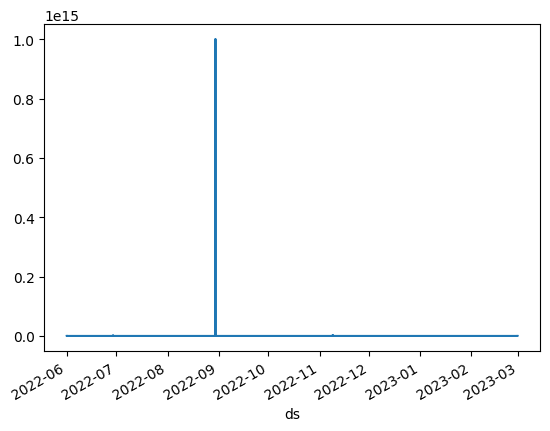

In [165]:
#Choose Time series
df1 = DF.copy()
df1.set_index('ds',inplace=True)
df1['ts'].plot()

# Dealing with outliers

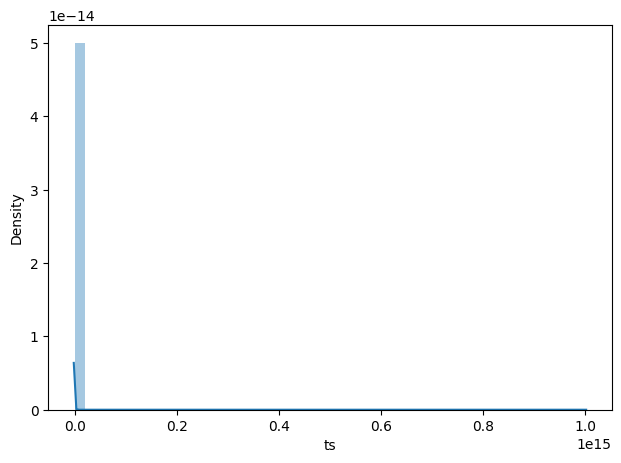

In [166]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(DF['ts'])
# plt.subplot(1,2,2)
# sns.distplot(df[''])
plt.show()

In [167]:
print("Highest allowed",DF['ts'].mean() + 3*DF['ts'].std())
print("Lowest allowed",DF['ts'].mean() - 3*DF['ts'].std())

Highest allowed 16662823755279.521
Lowest allowed -16600981251731.205


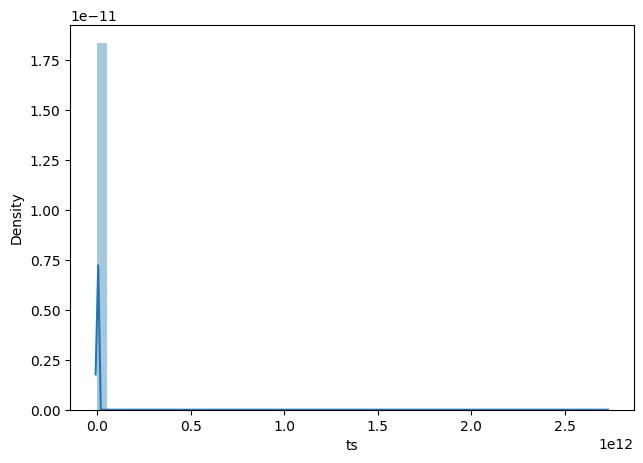

In [168]:
#Trim Outliers
new_df = DF["ts"][(DF['ts'] < DF['ts'].mean() + 3*DF['ts'].std()) & (DF['ts'] > DF['ts'].mean() - 3*DF['ts'].std())]
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(new_df)
# plt.subplot(1,2,2)
# sns.distplot(df[''])
plt.show()

## Skew

In [169]:
new_df.skew()

114.32555843929237

In [170]:
# Calculate logarithm to base 2 
# on 'Salary' column
new_df_log = np.log(new_df)
     

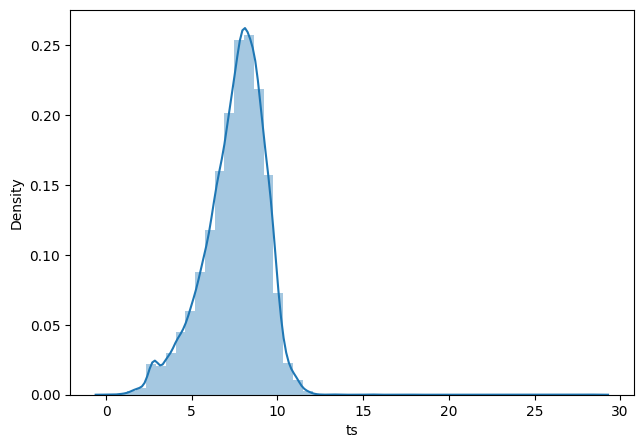

In [171]:

warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(new_df_log)
plt.show()

# Time Series Model

In [172]:
# Copy dataframe
DF['log_Sum_Unit_Price'] = np.log(DF['ts'])
DF = DF.copy()

In [173]:
# Drop nans
DF.dropna(inplace=True)

# Seasonal Decomposition

In [174]:
decomposition = seasonal_decompose(DF['ts'], period = 30, extrapolate_trend = 'freq')

In [175]:
Decom_Df = DF
Decom_Df.loc[:, "trend"] = decomposition.trend
Decom_Df.loc[:, "seasonal"] = decomposition.seasonal
Decom_Df.loc[:, "residual"] = decomposition.resid

In [176]:
# After performing seasonal decomposition, reset the index
Decom_Df = Decom_Df.reset_index(drop=True)

# Merge the 'Trend' column back into the original DataFrame
DF['trend'] = Decom_Df['trend']
DF.head(5)

,ts,ds,log_Sum_Unit_Price,trend,seasonal,residual
0,569.69,2022-07-06,6.345092,4397.532696,-3.089381e+10,3.089381e+10
1,4114.14,2022-11-06,8.322185,4368.727920,-3.089381e+10,3.089381e+10
2,2573.13,2023-02-09,7.852878,4339.923145,-3.089381e+10,3.089381e+10
3,4474.28,2022-06-08,8.406101,4311.118369,-3.089381e+10,3.089381e+10
4,11165.23,2022-11-19,9.320560,4282.313594,-3.089381e+10,3.089382e+10


In [177]:
def plot_decomposition(df, ts,trend,seasonal, residual):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original', c = 'b')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend', c = 'lime')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality', c = 'm')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals', c = 'r')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

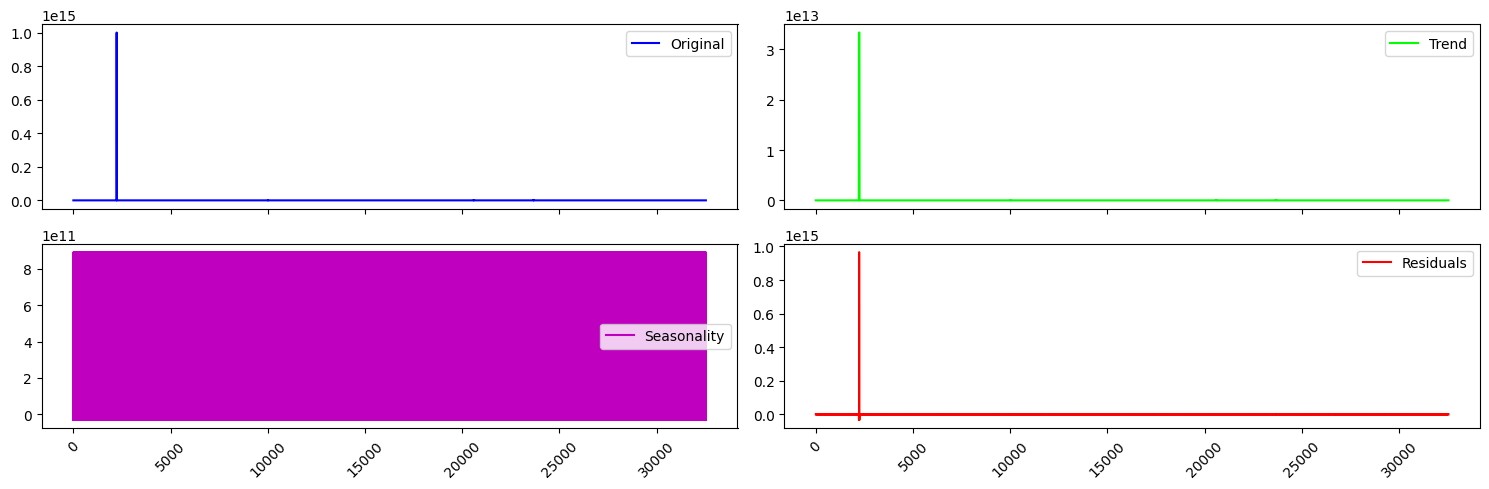

In [178]:
plot_decomposition(Decom_Df, ts = 'ts', trend = 'trend', seasonal = 'seasonal', residual = 'residual')

# Subtracting out the trend

In [ ]:
Decom_Df['No_Trend'] = Decom_Df.log_Sum_Unit_Price - Decom_Df.trend
Decom_Df.No_Trend.plot()
# Decom_Df.ts.plot()

# Apply different model on ts with trend subtracted

# An LSTM

## Data Prep

In [159]:
Decom_Df.set_index('ds',inplace=True)
Decom_Df.sort_index()

KeyError: "None of ['ds'] are in the columns"

In [23]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
Decom_Df['No_Trend'] = scaler.fit_transform(Decom_Df[['No_Trend']])

In [157]:
# Create sequences of fixed length (e.g., 30 time steps)
sequence_length = 30

X, y = [], []
for i in range(len(Decom_Df) - sequence_length):
    X.append(Decom_Df['No_Trend'].iloc[i:i + sequence_length])
    y.append(Decom_Df['No_Trend'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y.shape

(32505,)

## Training and Testing Sets

In [158]:
X_train,y_train,X_test,y_test = X[:int(0.8*len(X))],y[:int(0.8*len(X))],X[int(0.8*len(X)):],y[int(0.8*len(X)):]

## Model Architecture

In [59]:
# Create LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Model Training

In [61]:
# Train Model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/5
813/813 [==============================] - 27s 33ms/step - loss: 1.7172e-04 - val_loss: 9.5772e-09
Epoch 2/5
813/813 [==============================] - 28s 34ms/step - loss: 1.5823e-04 - val_loss: 1.4740e-05
Epoch 3/5
813/813 [==============================] - 28s 34ms/step - loss: 1.2322e-04 - val_loss: 5.0843e-08
Epoch 4/5
813/813 [==============================] - 28s 35ms/step - loss: 1.0223e-04 - val_loss: 2.4996e-07
Epoch 5/5
813/813 [==============================] - 28s 34ms/step - loss: 1.4787e-04 - val_loss: 2.7359e-11


## Model Predictions

In [151]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

204/204 [==============================] - 2s 10ms/step


In [135]:
# Inverse transform the predictions to put in terms of sales
# y_train_pred = scaler.inverse_transform(y_train_pred)
# y_test_pred = scaler.inverse_transform(y_test_pred)

In [152]:
trend_values = Decom_Df['trend'].values
trend_values.shape
# Calculate the trend values corresponding to the train and test sets

# trend_test = trend_values[int(0.8 * len(X)):].reshape(-1,1)
trend_xfunction_values = trend_values[:len(Decom_Df) - sequence_length]
trend_train = trend_xfunction_values[:int(0.8 * len(X))].reshape(-1,1)
trend_yfunction_values = trend_values[sequence_length:]
trend_test = trend_yfunction_values[int(0.8 * len(X)):].reshape(-1,1)

In [153]:
# Actuals
# y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Add Trend Back in

In [154]:
# Training predictions
y_train_pred1 = np.exp(trend_train.reshape(-1,1) + y_train_pred)
y_train_pred.shape

(26004, 1)

In [155]:
# Testing Predictions
y_test_pred1 = np.exp(trend_test.reshape(-1,1) + y_test_pred)

## Evaluation of Model Performance

In [156]:
# Evaluate Model
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred1))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred1))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

ValueError: Input contains infinity or a value too large for dtype('float64').

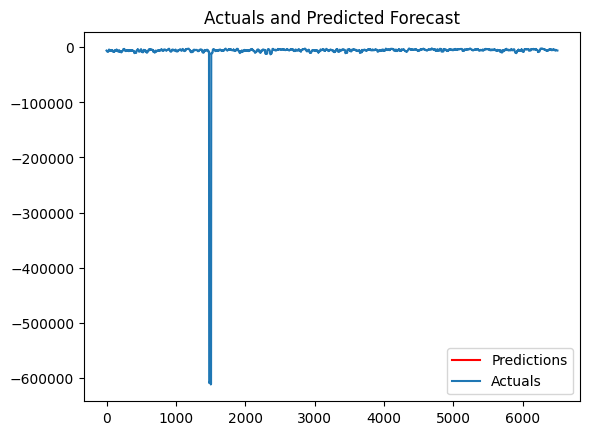

In [146]:
plt.plot(y_test_pred1,c='red',label='Predictions')
plt.title('Actuals and Predicted Forecast')
plt.plot(y_test_actual,label='Actuals')
plt.legend()
plt.show()

In [147]:
# R2
r2_score(y_test_actual, y_test_pred)

-2.0595647834155088e+34

# XGBoost Model